=== Task ==

Modify the KNN scratch code in our lecture such that:
1) If the majority class of the first place is equal to the second place, then ask the algorithm to pick the next nearest neighbours as the decider.

2) Modify the code so it outputs the probability of the decision, where the probability is simply the class probability based on all the nearest neighbours.

3) Write a function which allows the program to receive a range of k, and output the cross validation score. Last, it shall inform us which k is the best to use from a predefined range.

4)Put everything into a class KNN(k=3). It should have at least one method, predict(X_train, X_test, y_train).

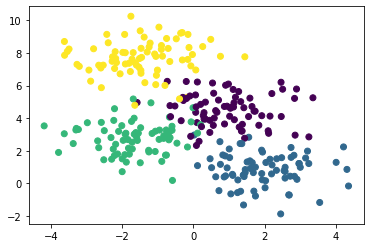

In [1]:
#let us consider the following 2D data with 4 classes
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y)

In [2]:
#standardize
scaler = StandardScaler()
X = scaler.fit_transform(X)

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [5]:
class KNN:
    def __init__(self, k=3):
        self.k = k
        
    def find_distance(self, X_train, X_test):
        #create new axis to broadcast to all values
        dist = X_test[:, np.newaxis, :] - X_train[np.newaxis, :, :]
        sq_dist = dist ** 2

        #sum across feature dimension, thus axis = 2
        summed_dist = sq_dist.sum(axis=2)
        sq_dist = np.sqrt(summed_dist)
        return sq_dist
    
    def find_neighbors(self, X_train, X_test):
        dist = self.find_distance(X_train, X_test)
        #return the first k neighbors
        neighbors_ix = np.argsort(dist)[:, 0:self.k]
        return neighbors_ix
    
    def find_neighbors_without_k(self, X_train, X_test):
        dist = self.find_distance(X_train, X_test)
        #return the first k neighbors
        neighbors_ix = np.argsort(dist)
        return neighbors_ix
    
    def get_most_common(self, y, n_classes, X_train, X_test):
        y_nearest = y[0:self.k]
        bincount = np.bincount(y_nearest, minlength=n_classes)
        largest = bincount.argmax()
        second_largest = bincount.argsort()[-2:][0]
        
        #if the first two most common is the same, we take the third most common as the decider
        if bincount[largest] == bincount[second_largest]:
            y_nearest = y[0: self.k+1]  #add one more neighbor
            return np.bincount(y_nearest).argmax(), bincount[largest] / bincount.sum()
        return np.bincount(y_nearest).argmax(), bincount[largest] / bincount.sum()
        
    def cv(self, X_train, y_train, cv, k):
        foldsize = int(X_train.shape[0]/cv)
        yhat_cv = np.zeros((len(k), cv))
        yhat_cv_prob = np.zeros((len(k), cv))
        
        for k_idx, kneighbors in enumerate(k):
            self.k = kneighbors
            for fold_idx, i in enumerate(range(0, X_train.shape[0], foldsize)):
                X_test_ = X_train[i:i+foldsize]
                y_test_ = y_train[i:i+foldsize]
                X_train_ = np.concatenate((X_train[:i], X_train[i+foldsize:]))
                y_train_ = np.concatenate((y_train[:i], y_train[i+foldsize:]))
                yhat, yhat_prob = self.predict(X_train_, X_test_, y_train_)
                accuracy = np.sum(yhat == y_test_)/len(y_test_)
                yhat_cv[k_idx, fold_idx] = accuracy
                yhat_cv_prob[k_idx, fold_idx] = yhat_prob.mean()
        return yhat_cv, yhat_cv_prob
        
    def predict(self, X_train, X_test, y_train):
        n_classes = len(np.unique(y_train))
        neighbors_ix = self.find_neighbors_without_k(X_train, X_test)
        yhat = np.zeros(X_test.shape[0])
        yhat_prob = np.zeros(X_test.shape[0])
        for ix, y in enumerate(y_train[neighbors_ix]):
            yhat[ix], yhat_prob[ix] = self.get_most_common(y, n_classes, X_train, X_test)
        return yhat, yhat_prob

In [6]:
model = KNN()
#check cv
k = np.arange(2, 11)
cv_score, prob_score = model.cv(X_train, y_train, 10, k)
cv_score = cv_score.mean(axis=1)
prob_score = prob_score.mean(axis=1)
for k_idx, kneighbors in enumerate(k):
    print(f"Score with k={kneighbors}: ", cv_score[k_idx], "and prob_score of ", prob_score[k_idx])

#choose model with highest score
model = KNN(k=2)
yhat, yhat_prob = model.predict(X_train, X_test, y_train)

print("====Accuracy====")
print("Accuracy: ", np.sum(yhat == y_test)/len(y_test))
print("====Classification report====")
print("Report: ", classification_report(y_test, yhat))
print("=====Probability score====")
print("Probability: ", yhat_prob.mean())

Score with k=2:  0.9047619047619048 and prob_score of  0.9571428571428571
Score with k=3:  0.9142857142857143 and prob_score of  0.946031746031746
Score with k=4:  0.9380952380952381 and prob_score of  0.9392857142857143
Score with k=5:  0.9380952380952381 and prob_score of  0.9352380952380953
Score with k=6:  0.9333333333333333 and prob_score of  0.930952380952381
Score with k=7:  0.9333333333333333 and prob_score of  0.9333333333333332
Score with k=8:  0.9285714285714286 and prob_score of  0.9303571428571427
Score with k=9:  0.9238095238095239 and prob_score of  0.928042328042328
Score with k=10:  0.9190476190476191 and prob_score of  0.921904761904762
====Accuracy====
Accuracy:  0.9333333333333333
====Classification report====
Report:                precision    recall  f1-score   support

           0       0.84      0.84      0.84        19
           1       0.96      0.96      0.96        26
           2       0.95      0.95      0.95        22
           3       0.96      0.96 